In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata

# -----------------------------
# 1) LOAD PMFs (keep this)
# -----------------------------
pmf_data1 = np.loadtxt('holo_p_meta.pmf')
pmf_data2 = np.loadtxt('holo_l_meta.pmf')
pmf_data3 = np.loadtxt('apo_p_meta.pmf')
pmf_data4 = np.loadtxt('apo_l_meta.pmf')

# optional (keep if you still want these extracted from pmf_data1)
dihedrals = pmf_data1[:, 0]
distances = pmf_data1[:, 1]


# -----------------------------
# 2) NORMALIZE (keep this logic)
# -----------------------------
def normalize(pmf_data):
    dihedrals = pmf_data[:, 0]
    distances = pmf_data[:, 1]
    energy = pmf_data[:, 2]

    suitable_lines = None

    target_distance = 33.8
    target_dihedral = 98

    distance_tolerance = 0.75
    dihedral_tolerance = 7

    for i in range(len(energy)):
        if (abs(distances[i] - target_distance) <= distance_tolerance) and \
           (abs(dihedrals[i] - target_dihedral) <= dihedral_tolerance):
            suitable_lines = energy[i]
            print(f"Suitable energy found at index {i}: {suitable_lines}")
            break

    if suitable_lines is None:
        print("No suitable match found. Using default processing.")
        suitable_lines = np.mean(energy)

    return energy - suitable_lines


# -----------------------------
# 3) BUILD 2D GRID (clean replacement for reshape/assert block)
# -----------------------------
def pmf_to_grid(pmf_data):
    """
    Convert PMF point list (phi, dist, E) into X_2D, Y_2D, Z_2D on a regular grid.
    Works even if ordering in the file is not reshape-friendly.
    """
    x = pmf_data[:, 0]  # dihedral
    y = pmf_data[:, 1]  # distance
    z = normalize(pmf_data)

    x_unique = np.unique(x)
    y_unique = np.unique(y)

    # mesh with shape (len(y), len(x)) for plotting convenience
    Xg, Yg = np.meshgrid(x_unique, y_unique)

    # fill Z via interpolation onto grid; if your PMF is already a perfect grid,
    # this will match it (and avoids reshape assumptions).
    Zg = griddata((x, y), z, (Xg, Yg), method="nearest")

    return Xg, Yg, Zg


X_2D1, Y_2D1, Z_energy_2D1 = pmf_to_grid(pmf_data1)
X_2D2, Y_2D2, Z_energy_2D2 = pmf_to_grid(pmf_data2)
X_2D3, Y_2D3, Z_energy_2D3 = pmf_to_grid(pmf_data3)
X_2D4, Y_2D4, Z_energy_2D4 = pmf_to_grid(pmf_data4)

# Print min/max (keep)
energy_datasets = [Z_energy_2D1, Z_energy_2D2, Z_energy_2D3, Z_energy_2D4]
for i, dataset in enumerate(energy_datasets, start=1):
    max_energy = np.nanmax(dataset)
    min_energy = np.nanmin(dataset)
    print(f"PMF Data {i}: Max Energy = {max_energy}, Min Energy = {min_energy}")

Suitable energy found at index 744: 15.2589
Suitable energy found at index 744: 4.32288
Suitable energy found at index 744: 7.05679
Suitable energy found at index 744: 2.05169
PMF Data 1: Max Energy = 12.643999999999998, Min Energy = -15.2589
PMF Data 2: Max Energy = 8.28332, Min Energy = -4.32288
PMF Data 3: Max Energy = 10.842310000000001, Min Energy = -7.05679
PMF Data 4: Max Energy = 10.25871, Min Energy = -2.05169


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata  # needed for the 3D plot section


def smooth_energy(Z_energy_2D, kernel_type='7x7'):
    """
    Apply smoothing using a Gaussian-like kernel to the Z_energy_2D data.
    """
    kernel_dict = {
        '3x3': np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16,
        '5x5': np.array([[1, 4, 6, 4, 1],
                         [4, 16, 24, 16, 4],
                         [6, 24, 36, 24, 6],
                         [4, 16, 24, 16, 4],
                         [1, 4, 6, 4, 1]]) / 256,
        '7x7': np.array([[1, 6, 15, 20, 15, 6, 1],
                         [6, 36, 90, 120, 90, 36, 6],
                         [15, 90, 225, 300, 225, 90, 15],
                         [20, 120, 300, 400, 300, 120, 20],
                         [15, 90, 225, 300, 225, 90, 15],
                         [6, 36, 90, 120, 90, 36, 6],
                         [1, 6, 15, 20, 15, 6, 1]]) / 4096
    }
    
    if kernel_type not in kernel_dict:
        raise ValueError("Invalid kernel type. Choose from '3x3', '5x5', or '7x7'.")
    
    kernel = kernel_dict[kernel_type]
    return convolve(Z_energy_2D, kernel)


def create_custom_colormap():
    """
    Create a custom colormap that transitions from #D2DCE6 (light) to #401B1B (dark).
    """
    colors = ['#91bfdb','#8fc3d1','#fff0c7','#f19c79','#9e040c']
    return LinearSegmentedColormap.from_list("custom_pmf", colors, N=256)


def plot_smoothed_energy_contour(ax, X_2D, Y_2D, Z_energy_2D, kernel_type='7x7'):
    """
    Plot the smoothed energy contour for given 2D energy data.
    """
    Z_energy_2D_smooth_g = smooth_energy(Z_energy_2D, kernel_type=kernel_type)
    
    # Clip values for contour visualization
    Z_energy_2D_smooth_g = np.clip(Z_energy_2D_smooth_g, -9, 6)
    
    
    # Create and apply the custom colormap
    cmap = create_custom_colormap()
    
    levels = np.linspace(-9, 6, 16)
    contourf = ax.contourf(X_2D, Y_2D, Z_energy_2D_smooth_g, levels=levels, cmap=cmap, alpha=0.6)
    ax.contour(X_2D, Y_2D, Z_energy_2D_smooth_g, levels=levels, colors='k', linewidths=0.9)

    ax.set_xlabel('Torsion angle(φ)(°)', fontsize=16)
    ax.set_ylabel(r'$l_{\mathit{linker}}$ (Å)', fontsize=16)
   
    return contourf


/var/folders/fx/s7zv3zv93zqg5n5t76zy46700000gn/T/ipykernel_2532/437032049.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


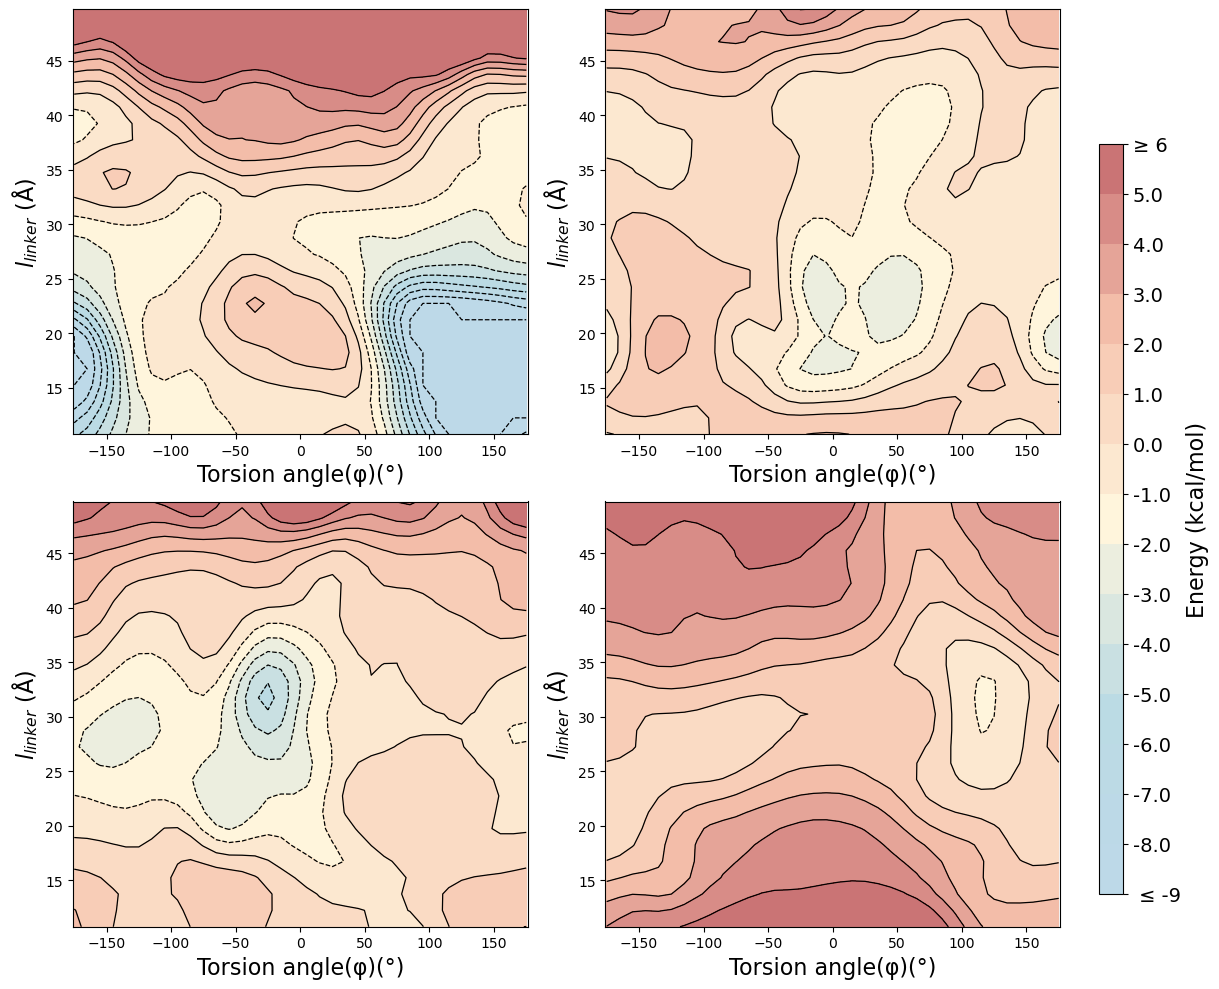

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

data_sets = [(X_2D1, Y_2D1, Z_energy_2D1),
             (X_2D2, Y_2D2, Z_energy_2D2),
             (X_2D3, Y_2D3, Z_energy_2D3),
             (X_2D4, Y_2D4, Z_energy_2D4)]

# Define the specific ranges for dihedral angles and distances
dihedral_range = np.linspace(-176, 176)
distance_range = np.linspace(10.75, 49.75)

contours = []
for i, (ax, (X, Y, Z)) in enumerate(zip(axes.flat, data_sets)):
    contours.append(plot_smoothed_energy_contour(ax, X, Y, Z))

    # Set limits
    ax.set_xlim(dihedral_range.min(), dihedral_range.max())
    ax.set_ylim(distance_range.min(), distance_range.max())

# Add a colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.75])  # [left, bottom, width, height]
cbar = fig.colorbar(contours[1], cax=cbar_ax)
cbar.set_label('Energy (kcal/mol)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Adjust colorbar ticks and labels
cbar_ticks = np.linspace(-9, 6, 16)
cbar.set_ticks(cbar_ticks)
cbar_labels = [f'{tick:.1f}' for tick in cbar_ticks]
cbar_labels[0] = ' ≤ -9'
cbar_labels[-1] = '≥ 6'
cbar.set_ticklabels(cbar_labels)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('pmf_2D_plots.png', format='png', dpi=300)
plt.show()


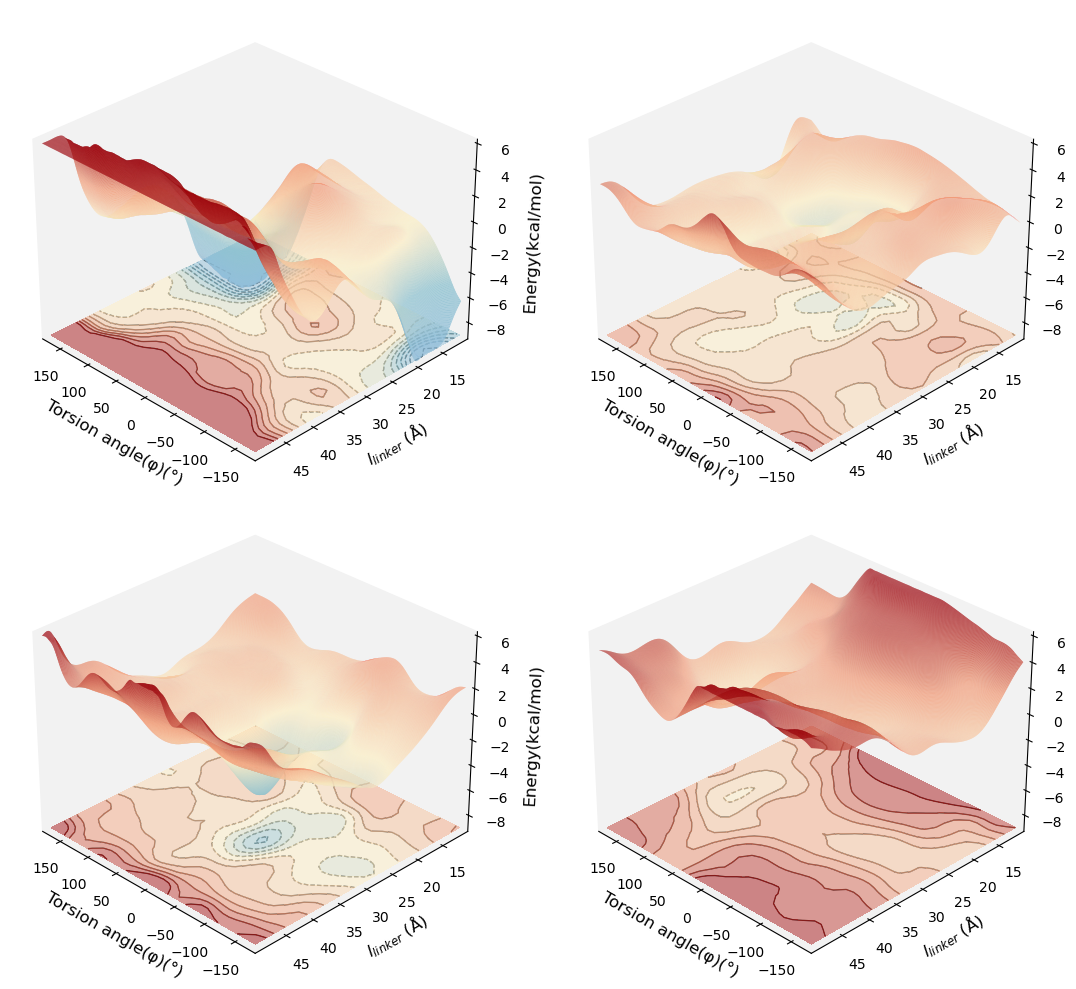

In [4]:
def interpolate_grid(X, Y, Z, resolution=150):
    """
    Interpolates the given grid to a higher resolution to avoid square artifacts.
    """
    x_new = np.linspace(X.min(), X.max(), resolution)
    y_new = np.linspace(Y.min(), Y.max(), resolution)
    X_new, Y_new = np.meshgrid(x_new, y_new)
    Z_new = griddata((X.flatten(), Y.flatten()), Z.flatten(),
                     (X_new, Y_new), method='cubic')
    return X_new, Y_new, Z_new


def plot_smoothed_energy_3D_with_contour(ax, X_2D, Y_2D, Z_energy_2D, kernel_type='7x7'):
    """
    Plot the smoothed energy as a 3D surface with a fixed 2D contour projection at z = -9.
    """
    # ✅ Apply smoothing and clip values correctly
    Z_energy_2D_smooth_g = smooth_energy(Z_energy_2D, kernel_type=kernel_type)
    Z_energy_2D_smooth_g = np.clip(Z_energy_2D_smooth_g, -9, 6)  # Ensure values are in range [-9, 6]

    # ✅ Use the correct colormap
    cmap2 = create_custom_colormap()
    
    # ✅ Interpolate grid for a smoother surface
    X_2D_interp, Y_2D_interp, Z_energy_2D_interp = interpolate_grid(
        X_2D, Y_2D, Z_energy_2D_smooth_g, resolution=400
    )

    # ✅ Interpolate `masked_Z` for contour plot
    masked_Z_interp = np.ma.masked_where(Z_energy_2D_interp > 0, Z_energy_2D_interp)

    # ✅ 3D Surface Plot with the correct colormap and fine resolution
    surf = ax.plot_surface(
        X_2D_interp, Y_2D_interp, Z_energy_2D_interp,
        cmap=cmap2, edgecolor='none',
        vmin=-9, vmax=6, rstride=1, cstride=1
    )

    # ✅ Set contour projection at Z = -9 (fixed)
    z_contour = -9
    levels = np.linspace(-9, 6, 16)  # Define contour levels with correct range

    # ✅ 2D Contour Fill (colored contours at z = -9)
    contourf = ax.contourf(
        X_2D, Y_2D, Z_energy_2D_smooth_g,
        zdir='z', offset=z_contour,
        levels=levels, cmap=cmap2, alpha=0.5
    )
    
    # ✅ 2D Contour Lines (black contour edges)
    ax.contour(
        X_2D, Y_2D, Z_energy_2D_smooth_g,
        zdir='z', offset=z_contour,
        levels=levels, colors='k', linewidths=0.9
    )

    # Labels and view adjustments
    ax.set_xlabel('Torsion angle(φ)(°)', fontsize=12)
    ax.set_ylabel(r'$l_{\mathit{linker}}$ (Å)', fontsize=12)
    ax.set_zlabel('Energy(kcal/mol)', fontsize=12)

    ax.set_zlim(-9, 6)                      # keep your original z-range
    ax.view_init(elev=30, azim=135)
    ax.grid(False)

    # -------- FIXES --------
    # outside figure background white
    ax.set_facecolor('white')

    # keep light grey panes (box appearance), but slightly lighter than default
    ax.xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
    ax.yaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
    ax.zaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))

    # remove x/y padding so contour plane touches axes (no gap)
    ax.set_xlim(X_2D.min(), X_2D.max())
    ax.set_ylim(Y_2D.min(), Y_2D.max())
    # -----------------------

    return surf, contourf


# Example usage
fig = plt.figure(figsize=(12, 10))

data_sets = [
    (X_2D1, Y_2D1, Z_energy_2D1),
    (X_2D2, Y_2D2, Z_energy_2D2),
    (X_2D3, Y_2D3, Z_energy_2D3),
    (X_2D4, Y_2D4, Z_energy_2D4)
]

for i, (X, Y, Z) in enumerate(data_sets):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')  # 3D subplot
    surf, contourf = plot_smoothed_energy_3D_with_contour(ax, X, Y, Z)

plt.tight_layout()
plt.savefig('pmf_3D_plots_with_fixed_contour.png', format='png', dpi=300)
plt.show()


/var/folders/fx/s7zv3zv93zqg5n5t76zy46700000gn/T/ipykernel_2532/930361693.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


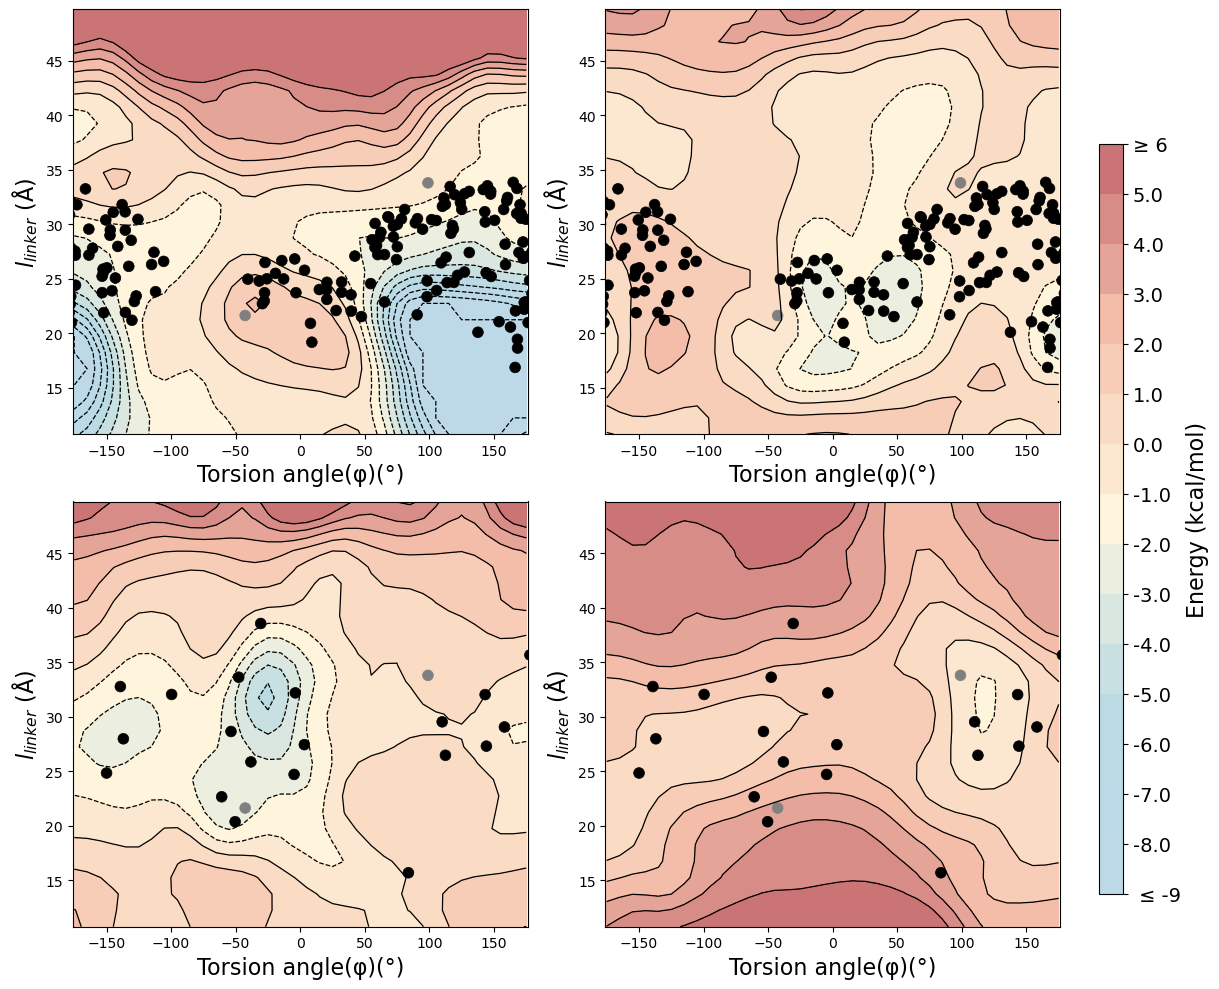

In [5]:
# Load and prepare scatter data
def load_data(file_name):
    """Load NMR data from a given file name."""
    return np.loadtxt(file_name)

def prepare_data(data):
    """Extract and prepare X, Y, and Z data from loaded NMR data."""
    dihedrals = data[:, 0]
    distances = data[:, 1]
    energy = data[:, 2]
    return dihedrals, distances, energy

# Helper to color specific Z values while preserving gray for z==6 and black fallback (mavi yeşil mor pembe)
def value_to_color(z):
    if z == 10.0:
        return '#4B6CB7'
    if z == 11.0:
        return '#2C7A7B'
    if z == 12.0:
        return '#8E4585'
    if z == 5.0:
        return '#C45A87'
    if z == 6.0:
        return 'gray'
    return 'black'

# Example usage
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

data_sets = [(X_2D1, Y_2D1, Z_energy_2D1),
             (X_2D2, Y_2D2, Z_energy_2D2),
             (X_2D3, Y_2D3, Z_energy_2D3),
             (X_2D4, Y_2D4, Z_energy_2D4)]

# Load scatter data
file_name_1 = 'holo.txt'
file_name_2 = 'apo.txt'
data1 = load_data(file_name_1)
data2 = load_data(file_name_2)
X1, Y1, Z1 = prepare_data(data1)
X2, Y2, Z2 = prepare_data(data2)

# Precompute colors including new mapping
colors1 = [value_to_color(z) for z in Z1]
colors2 = [value_to_color(z) for z in Z2]

# Define sizes — larger for colored points
sizes1 = [80 if value_to_color(z) not in ['gray', 'black'] else 60 for z in Z1]
sizes2 = [80 if value_to_color(z) not in ['gray', 'black'] else 60 for z in Z2]

# Define the specific ranges for dihedral angles and distances
dihedral_range = np.linspace(-176, 176)
distance_range = np.linspace(10.75, 49.75)

contours = []
for i, (ax, (X, Y, Z)) in enumerate(zip(axes.flat, data_sets)):
    contours.append(plot_smoothed_energy_contour(ax, X, Y, Z))

    # Overlay scatter points from the NMR data
    if i < 2:  # Top row gets holo data
        if i == 0:  # X_2D1: show colored (large)
            ax.scatter(X1, Y1, c=colors1, s=sizes1, alpha=1.0, linewidth=0.5)
        else:  # X_2D2: only black/gray
            ax.scatter(X1, Y1, c=['gray' if z == 6 else 'black' for z in Z1],
                       s=60, alpha=1.0, linewidth=0.5)
    else:  # Bottom row gets apo data
        if i == 2:  # X_2D3: show colored (large)
            ax.scatter(X2, Y2, c=colors2, s=sizes2, alpha=1.0, linewidth=0.5)
        else:  # X_2D4: only black/gray
            ax.scatter(X2, Y2, c=['gray' if z == 6 else 'black' for z in Z2],
                       s=60, alpha=1.0, linewidth=0.5)

    # Set limits
    ax.set_xlim(dihedral_range.min(), dihedral_range.max())
    ax.set_ylim(distance_range.min(), distance_range.max())

# Add a colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.75])  # [left, bottom, width, height]
cbar = fig.colorbar(contours[1], cax=cbar_ax)
cbar.set_label('Energy (kcal/mol)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# Adjust colorbar ticks and labels
cbar_ticks = np.linspace(-9, 6, 16)
cbar.set_ticks(cbar_ticks)
cbar_labels = [f'{tick:.1f}' for tick in cbar_ticks]
cbar_labels[0] = ' ≤ -9'
cbar_labels[-1] = '≥ 6'
cbar.set_ticklabels(cbar_labels)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('overlayed_plot.png', format='png', dpi=300)
plt.show()


In [6]:
# --- pick your RANGE here (inclusive) ---
x_min, x_max = 100.0, 115.0   # phi (deg)
y_min, y_max = 31.0, 33.0     # linker (Å)

datasets = [
    ("PMF1", X_2D1, Y_2D1, Z_energy_2D1),
    ("PMF2", X_2D2, Y_2D2, Z_energy_2D2),
    ("PMF3", X_2D3, Y_2D3, Z_energy_2D3),
    ("PMF4", X_2D4, Y_2D4, Z_energy_2D4),
]

vals = []
for name, X2, Y2, Z2 in datasets:
    mask = (X2 >= x_min) & (X2 <= x_max) & (Y2 >= y_min) & (Y2 <= y_max)

    if not np.any(mask):
        # no grid points in the selected range
        vals.append((np.inf, name, np.nan, np.nan))
        continue

    # find minimum energy inside the range
    Zmasked = np.where(mask, Z2, np.inf)
    i, j = np.unravel_index(np.argmin(Zmasked), Zmasked.shape)

    vals.append((float(Z2[i, j]), name, float(X2[i, j]), float(Y2[i, j])))

emin, which, x_used, y_used = min(vals, key=lambda t: t[0])

print(f"Query range: x=[{x_min}, {x_max}], y=[{y_min}, {y_max}]")
for E, name, xu, yu in vals:
    if np.isfinite(E):
        print(f"{name}: min E={E:.6f} at (x={xu:.3f}, y={yu:.3f})")
    else:
        print(f"{name}: no grid points in this range")

if np.isfinite(emin):
    print(f"\nMinimum across 4 PMFs in the range: {emin:.6f} from {which} at (x={x_used:.3f}, y={y_used:.3f})")
else:
    print("\nNo grid points in this range for any PMF.")


Query range: x=[100.0, 115.0], y=[31.0, 33.0]
PMF1: min E=-1.065600 at (x=105.000, y=31.750)
PMF2: min E=-0.787630 at (x=105.000, y=31.750)
PMF3: min E=0.241870 at (x=115.000, y=31.750)
PMF4: min E=-1.563174 at (x=115.000, y=31.750)

Minimum across 4 PMFs in the range: -1.563174 from PMF4 at (x=115.000, y=31.750)
